# MultiplEYE preprocessing

In [1]:
from pathlib import Path
import polars as pl
import pandas as pd
import re
import json
import PIL
import math
from sanity import extract_informatio_file_path
from report import load_data, check_gaze, check_metadata, check_events, report_to_file as report_meta, plot_main_sequence
from functools import partial
from plot import plot_gaze


import pymovements as pm

In [21]:
# Create a dictionary with all the relevant information from the file path


path_asc_file = "data\\017_NL_NL_1_ET1_testrun_1733144369\\017nlnl1.asc"
#path_asc_file ="data\\016_NL_NL_1_ET1\\016nlnl1.asc"
#path_asc_file= "data\\010_ZH_CH_1_ET1\\010zhch1.asc"
#path_asc_file = "data\\003_HR_HR_1_ET1\\003hrhr1.asc"
local_file_part = "C:\\Users\saphi\PycharmProjects\multipleye-preprocessing"
stimulus_file_path = "C:\\Users\saphi\PycharmProjects\multipleye-preprocessing\data\stimuli_MultiplEYE_NL_NL_Nijmegen_1_2024"
#stimulus_file_path = "C:\\Users\saphi\PycharmProjects\multipleye-preprocessing\data\stimuli_MultiplEYE_ZH_CH_Zurich_1_2025"


logfile_path = f"C:\\Users\saphi\PycharmProjects\multipleye-preprocessing\data\\017_NL_NL_1_ET1_testrun_1733144369\logfiles\EXPERIMENT_LOGFILE_1_017_2024-12-02_1733144369.txt"
logfile_path = f"C:\\Users\saphi\PycharmProjects\multipleye-preprocessing\data\\010_ZH_CH_1_ET1\logfiles\EXPERIMENT_LOGFILE_1_010_2024-11-15_1731682963.txt"


    
vars_dict = extract_informatio_file_path(path_asc_file, local_file_part, stimulus_file_path, logfile_path)



Match was found at 5-52: 017_NL_NL_1_ET1_testrun_1733144369\017nlnl1.asc
Group 1 found at 5-8: 017
Group 2 found at 9-11: NL
Group 3 found at 12-14: NL
Group 4 found at 15-16: 1
Group 5 found at 17-20: ET1
Group 6 found at 20-39: _testrun_1733144369
Group 7 found at 40-48: 017nlnl1
C:\Users\saphi\PycharmProjects\multipleye-preprocessing\quality-report\output\NL_NL_Nijmegen_1_2024
True


In [22]:
vars_dict["asc_file"]


WindowsPath('C:/Users/saphi/PycharmProjects/multipleye-preprocessing/data/017_NL_NL_1_ET1_testrun_1733144369/017nlnl1.asc')

In [23]:
def report_to_file(message: str, report_file =vars_dict["report_file"]):
    with open(report_file, "a", encoding="utf-8") as report_file:
        report_file.write(f"{message}\n")
 

In [24]:
from stimulus import Stimulus
stimulus_dir = vars_dict["stimulus_file_path"]
lang = vars_dict["lang"].lower()

country = vars_dict["country"].lower()

labnum = vars_dict["labnum"]
stimulus_name = "PopSci_MultiplEYE"

stimulus = Stimulus.load(stimulus_dir, lang, country, labnum, stimulus_name)
for page in stimulus.pages:
    print(page.number, page.image_path)


1 C:\Users\saphi\PycharmProjects\multipleye-preprocessing\data\stimuli_MultiplEYE_NL_NL_Nijmegen_1_2024\stimuli_images_nl_nl_1\popsci_multipleye_id1_page_1_nl.png
2 C:\Users\saphi\PycharmProjects\multipleye-preprocessing\data\stimuli_MultiplEYE_NL_NL_Nijmegen_1_2024\stimuli_images_nl_nl_1\popsci_multipleye_id1_page_2_nl.png
3 C:\Users\saphi\PycharmProjects\multipleye-preprocessing\data\stimuli_MultiplEYE_NL_NL_Nijmegen_1_2024\stimuli_images_nl_nl_1\popsci_multipleye_id1_page_3_nl.png
4 C:\Users\saphi\PycharmProjects\multipleye-preprocessing\data\stimuli_MultiplEYE_NL_NL_Nijmegen_1_2024\stimuli_images_nl_nl_1\popsci_multipleye_id1_page_4_nl.png
5 C:\Users\saphi\PycharmProjects\multipleye-preprocessing\data\stimuli_MultiplEYE_NL_NL_Nijmegen_1_2024\stimuli_images_nl_nl_1\popsci_multipleye_id1_page_5_nl.png
6 C:\Users\saphi\PycharmProjects\multipleye-preprocessing\data\stimuli_MultiplEYE_NL_NL_Nijmegen_1_2024\stimuli_images_nl_nl_1\popsci_multipleye_id1_page_6_nl.png
7 C:\Users\saphi\Pycha

In [25]:

with open (vars_dict["json"]) as f:
    lab_config = json.load(f)
lab_config

{'Contact information': {'First_name': 'Stefan',
  'Last_name': 'Frank',
  'Affiliation': 'Radboud University',
  'Email': 'stefan.frank@ru.nl',
  'Phone': ''},
 'Data_collection_name': 'MultiplEYE_NL_NL_Nijmegen_1_2024',
 'Preregistration_core_or_additional_data_collection': 'pre-registration for core dataset',
 'Name_eye-tracker': 'EyeLink 1000 Plus',
 'Name_eye-tracker_manufacturer': 'SR Research',
 'Specification_camera_system': 'desktop mount',
 'Name_computer_operation_system': 'Windows 10',
 'Name_monitor': ['XL2430T', 'BenQ'],
 'Monitor_resolution_in_px': '(3840,2160)',
 'Screen_size_in_cm': '(59.8,33.6)',
 'Distance_in_cm': '60',
 'Script_direction': 'LTR',
 'Language_code': 'NL',
 'Country_code': 'NL',
 'Lab_number': '1',
 'City': 'Nijmegen',
 'Estimated_end_year_of_data_collection': '2024',
 'Use_of_multiple_devices': 'No',
 'Stimuli_preparation': ['Stimuli will be or has been prepared by our own lab'],
 'Psychometric_tests': {'Are_tests_conducted': 'No',
  'LWMC': '',
  'PL

## ASC to sample-level CSV

Convert the ASC files to CSV files (one for each page) where each row is a sample.

In [26]:
import importlib
stimulus_config_spec = importlib.util.spec_from_file_location(
        "stimulus_config", vars_dict["experiment_config"]
    )

stimulus_config = importlib.util.module_from_spec(stimulus_config_spec)
stimulus_config_spec.loader.exec_module(stimulus_config)

stimulus_config.IMAGE_WIDTH_PX

2375

In [27]:
from plot import load_data
from stimulus import load_stimuli
stimuli, lab_config = load_stimuli(vars_dict["stimulus_file_path"], vars_dict["lang"], vars_dict["country"], vars_dict["labnum"])
gaze = load_data(vars_dict['asc_file'], lab_config)

In [28]:
gaze.frame

time,pupil,activity,stimulus,practice,screen,trial,pixel
i64,f64,str,str,bool,str,str,list[f64]
1335359,1178.0,"""reading""","""Lit_NorthWind_7""",true,"""page_1""","""PRACTICE_trial_1""","[1194.9, 877.0]"
1335361,1178.0,"""reading""","""Lit_NorthWind_7""",true,"""page_1""","""PRACTICE_trial_1""","[1194.3, 877.7]"
1335363,1179.0,"""reading""","""Lit_NorthWind_7""",true,"""page_1""","""PRACTICE_trial_1""","[1193.9, 877.7]"
1335365,1179.0,"""reading""","""Lit_NorthWind_7""",true,"""page_1""","""PRACTICE_trial_1""","[1194.3, 876.9]"
1335367,1180.0,"""reading""","""Lit_NorthWind_7""",true,"""page_1""","""PRACTICE_trial_1""","[1194.7, 875.7]"
…,…,…,…,…,…,…,…
6853775,1153.0,"""question""","""PopSci_Caveman_12""",false,"""question_12132""","""trial_10""","[2254.5, 1589.8]"
6853777,1153.0,"""question""","""PopSci_Caveman_12""",false,"""question_12132""","""trial_10""","[2254.5, 1588.2]"
6853779,1153.0,"""question""","""PopSci_Caveman_12""",false,"""question_12132""","""trial_10""","[2254.7, 1586.8]"


In [29]:
gaze.frame.filter(pl.col("stimulus") == "PopSci_Caveman_12").filter(pl.col("activity") == "rating")

time,pupil,activity,stimulus,practice,screen,trial,pixel
i64,f64,str,str,bool,str,str,list[f64]


In [30]:
gaze._metadata


{'weekday': 'Mon',
 'month': 'Dec',
 'day': 2,
 'time': '00:15:26',
 'year': 2024,
 'version_1': 'EYELINK II 1',
 'version_2': 'EYELINK II CL v4.594 Jul  6 2012',
 'resolution': (2376, 1801),
 'tracking_mode': 'CR',
 'sampling_rate': 500.0,
 'file_sample_filter': '2',
 'link_sample_filter': '1',
 'tracked_eye': 'L',
 'mount_configuration': {'mount_type': 'Desktop',
  'head_stabilization': 'stabilized',
  'eyes_recorded': 'monocular',
  'short_name': 'MTABLER'},
 'pupil_data_type': 'AREA',
 'version_number': '4.594',
 'model': 'EyeLink 1000',
 'datetime': datetime.datetime(2024, 12, 2, 0, 15, 26),
 'calibrations': [{'timestamp': '1307711.0',
   'num_points': '9',
   'type': 'P-CR',
   'tracked_eye': 'LEFT'},
  {'timestamp': '1654534.0',
   'num_points': '9',
   'type': 'P-CR',
   'tracked_eye': 'LEFT'},
  {'timestamp': '2404756.0',
   'num_points': '9',
   'type': 'P-CR',
   'tracked_eye': 'LEFT'},
  {'timestamp': '2459282.0',
   'num_points': '9',
   'type': 'P-CR',
   'tracked_eye': '

In [31]:
lab_config

LabConfig(screen_resolution=(3840, 2160), screen_size_cm=(59.8, 33.6), screen_distance_cm=60.0)

In [12]:
report_file_2 = open(f"{vars_dict['output_dir']}/{vars_dict['participant_abbr']}_report2.txt", "w", encoding="utf-8")
report = partial(report_meta, report_file=report_file_2)
check_gaze(gaze, report)    
check_metadata(gaze._metadata, report)

In [13]:
from plot import preprocess
preprocess(gaze)


C:\Users\saphi\multipleye-preprocessing_2\Lib\site-packages\pymovements\events\detection\_microsaccades.py:194: RuntimeWarning: All-NaN slice encountered
  thx = np.sqrt(np.nanmedian(np.power(arr[:, 0] - np.nanmedian(arr[:, 0]), 2)))
C:\Users\saphi\multipleye-preprocessing_2\Lib\site-packages\pymovements\events\detection\_microsaccades.py:195: RuntimeWarning: All-NaN slice encountered
  thy = np.sqrt(np.nanmedian(np.power(arr[:, 1] - np.nanmedian(arr[:, 1]), 2)))


In [14]:
check_events(gaze, report)

In [15]:
plot_dir = vars_dict["output_dir"] / f"{vars_dict['participant_abbr']}_plots"
plot_dir.mkdir(exist_ok=True)

plot_main_sequence(gaze.events, plot_dir)

In [16]:
print(plot_dir)
test = (gaze.frame.filter(pl.col("stimulus") == "PopSci_Caveman_12").filter(pl.col("trial") == "trial_10"))
       
print(test)

C:\Users\saphi\PycharmProjects\multipleye-preprocessing\quality-report\output\ZH_CH_Zurich_1_2025\010zhch1_plots
shape: (0, 10)
┌──────┬───────┬──────────┬──────────┬───┬───────┬───────────┬───────────┬───────────┐
│ time ┆ pupil ┆ activity ┆ stimulus ┆ … ┆ trial ┆ pixel     ┆ position  ┆ velocity  │
│ ---  ┆ ---   ┆ ---      ┆ ---      ┆   ┆ ---   ┆ ---       ┆ ---       ┆ ---       │
│ i64  ┆ f64   ┆ str      ┆ str      ┆   ┆ str   ┆ list[f64] ┆ list[f64] ┆ list[f64] │
╞══════╪═══════╪══════════╪══════════╪═══╪═══════╪═══════════╪═══════════╪═══════════╡
└──────┴───────┴──────────┴──────────┴───┴───────┴───────────┴───────────┴───────────┘


In [17]:
print(gaze.events)

shape: (4_019, 10)
┌────────────┬────────────┬─────────┬──────────┬───┬──────────┬────────────┬───────────┬───────────┐
│ trial      ┆ stimulus   ┆ screen  ┆ name     ┆ … ┆ duration ┆ location   ┆ amplitude ┆ peak_velo │
│ ---        ┆ ---        ┆ ---     ┆ ---      ┆   ┆ ---      ┆ ---        ┆ ---       ┆ city      │
│ str        ┆ str        ┆ str     ┆ str      ┆   ┆ i64      ┆ list[f64]  ┆ f64       ┆ ---       │
│            ┆            ┆         ┆          ┆   ┆          ┆            ┆           ┆ f64       │
╞════════════╪════════════╪═════════╪══════════╪═══╪══════════╪════════════╪═══════════╪═══════════╡
│ PRACTICE_t ┆ Enc_WikiMo ┆ page_1  ┆ fixation ┆ … ┆ 138      ┆ [177.13525 ┆ null      ┆ null      │
│ rial_1     ┆ on_13      ┆         ┆          ┆   ┆          ┆ 2,         ┆           ┆           │
│            ┆            ┆         ┆          ┆   ┆          ┆ 94.453237] ┆           ┆           │
│ PRACTICE_t ┆ Enc_WikiMo ┆ page_1  ┆ fixation ┆ … ┆ 290      ┆ [50.1130

Plotting PopSci_MultiplEYE...
Plotting Ins_HumanRights...
Plotting Ins_LearningMobility...
Plotting Lit_Alchemist...
Plotting Lit_MagicMountain...
Plotting Lit_Solaris...
Plotting Lit_BrokenApril...
Plotting Arg_PISACowsMilk...
Plotting Arg_PISARapaNui...


KeyboardInterrupt: 

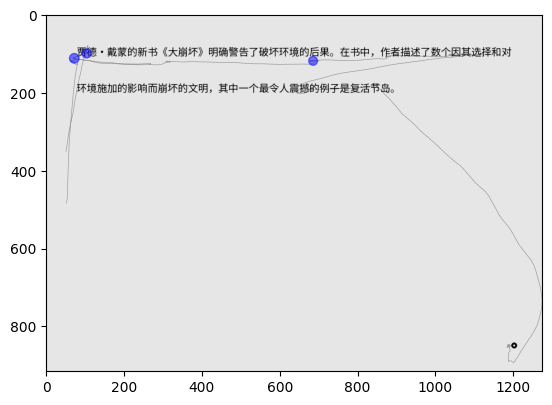

In [18]:
from plot import plot_gaze
for stimulus in stimuli:
    print(f"Plotting {stimulus.name}...")
    plot_gaze(gaze, stimulus, plot_dir)


In [ ]:

logfile= pl.read_csv(logfile_path, separator="\t")

In [ ]:
logfile

In [ ]:
stimulus_frame = logfile.filter(
              (pl.col("stimulus_number") == f"{11}")
            )
stimulus_frame.write_csv("stimulus_frame.csv")
stimulus_frame

In [ ]:


print(stimuli)
def check_all_screens_logfile(logfile: pl, stimuli: Stimulus):
    for stimulus in stimuli:
        print(f"Checking {stimulus.name} in Logfile")
        stimulus_frame = logfile.filter(
              (pl.col("stimulus_number") == f"{stimulus.id}")
            )
        # check if all pages are present        
        for page in stimulus.pages:
            if f"{page.number}" not in stimulus_frame["page_number"].to_list():
                print(f"Missing page {stimulus.name} {page.number} in Logfile")  
                report_to_file(f"Missing page {stimulus.name} {page.number} in Logfile")
        # check if all questions are present              
        for question in stimulus.questions:
            if f"{question.id}" not in stimulus_frame["page_number"].to_list() and f"{question.id[1:]}" not in stimulus_frame["page_number"].to_list():
                print(f"Missing question_{question.id}")
                report_to_file(f"Missing question_{question.id} in Logfile")
                print(stimulus_frame["screen"])
      
check_all_screens_logfile(logfile, stimuli)

In [ ]:
## check if all pages screens ect are present


def check_all_screens(gaze, stimuli):
    """ checking if all screens, where ET data is tracked are present in the gaze data frame, which is based on the ASC file
    it checks for all stimuli, if all pages and questions screens are present;it does not check for valditaion, calibration, instructions, etc.
    """
    for stimulus in stimuli:
        print(f"Checking {stimulus.name}")
        stimulus_frame = gaze.frame.filter(
              (pl.col("stimulus") == f"{stimulus.name}_{stimulus.id}")
            ).unique("screen")
        # check if all pages are present        
        for page in stimulus.pages:
            if f"page_{page.number}" not in stimulus_frame["screen"].to_list():
                print(f"Missing page {page.number}")  
                report_to_file(f"Missing page {page.number} in asc file")
        # check if all questions are present              
        for question in stimulus.questions:
            if f"question_{question.id}" not in stimulus_frame["screen"].to_list() and f"question_{question.id[1:]}" not in stimulus_frame["screen"].to_list():
                print(f"Missing question_{question.id}")
                report_to_file(f"Missing question_{question.id} in asc file")
                print(stimulus_frame["screen"])
      
check_all_screens(gaze, stimuli)

In [ ]:
def load_messages(asc_file: Path, REGEX):
    with open(asc_file, "r", encoding="utf-8") as f:
        lines = f.readlines()
    messages = []
    for line in lines:
        match = re.match(REGEX, line)
        if match:
            messages.append(match.groupdict())
    return messages

REGEX = r'MSG\s+(?P<timestamp>\d+[.]?\d*)\s+(?P<message>\w+)'


messages = load_messages(vars_dict["asc_file"], REGEX)

In [ ]:
print(messages)

In [ ]:
stimulus = stimuli[2]
stimulus.name, stimulus.pages[0]

In [ ]:
stimuli[0]

In [ ]:
# check practice trials
def check_instructions(messages, stimuli):
    messages_only = [d.get('message') for d in messages]
    one_time_screens = ['welcome_screen', 'informed_consent_screen', 'start_experiment', 'stimulus_order_version', 'showing_instruction_screen_1', 'showing_instruction_screen_2', 'showing_instruction_screen_3', 'camera_setup_screen', 'practice_text_starting_screen', 'start_recording_PRACTICE_trial_1_stimulus_Lit_NorthWind_7_page_1','stop_recording_PRACTICE_trial_1_stimulus_Lit_NorthWind_7_page_1', 'start_recording_PRACTICE_trial_1_stimulus_Lit_NorthWind_7_page_2', 'stop_recording_PRACTICE_trial_1_stimulus_Lit_NorthWind_7_page_2','transition_screen', 'final_validation', 'show_final_screen', 'obligatory_break', 'obligatory_break_end']
    optional_screens = ['empty_screen', 'optional_break_screen']
    reoccuring_screens = ['subject_difficulty_screen', 'familiarity_rating_screen_1','familiarity_rating_screen_2','validation_screen', 'recalibration_screen']
    reoccuring_msg = ['start_recording', 'stop_recording']
    
    

    for stimulus in stimuli:
       # print(stimulus.instructions)
        print(f"Checking {stimulus.name}")
        for instruction in reoccuring_screens:
            if f"showing_{instruction}" not in messages_only:
                print(f"Missing instruction {instruction}")
                report_to_file(f"Missing instruction {instruction} in asc file")
                
            else:
                print(f"Instruction {instruction} found")
               
       
        for instruction in reoccuring_msg:
            # stop_recording_trial_10_stimulus_PopSci_Caveman_12_page_8
            # start_recording_trial_10_stimulus_PopSci_Caveman_12_page_8
            # start_recording_trial_10_familiarity_rating_screen_1
            if f"{instruction}_trial_{stimulus.name}_" not in messages_only:
                print(f"Missing  {instruction} Messages in ASC file")
            else:
                print(f"{instruction} found")
                
    for one_time_screen in one_time_screens:
        if f"{one_time_screen}" not in messages_only:
            print(f"Missing screen {one_time_screen}")
            report_to_file(f"Missing one time screen {one_time_screen} in asc file")
        else:
            print(f"{one_time_screen} found")
    for optional_screen in optional_screens:
        if f"{optional_screen}" in messages_only:
            report_to_file(f"Optional screen {optional_screen} found in asc file")
            print(f"{optional_screen} found")

check_instructions(messages, stimuli)

In [ ]:
for instruction in stimuli[0][0].instructions:
    print(instruction.name)

In [ ]:
 for instruction in ["practice_trial_screen_1", "practice_trial_screen_2"]:
            if f"showing_{instruction}" not in messages_only:
                print(f"Missing instruction {instruction}")
                report_to_file(f"Missing instruction {instruction} in asc file")
            else:
                print(f"Instruction {instruction} found")